In [1]:
import torch

import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

from EVO import LogisticRegression, DeepNeuralNetwork, EvolutionOptimizer, GradientDescentOptimizer, seed_dnn_from_logistic

In this notebook, I will investigate how different diversity metrics can be used to evaluate and guide the evolution of weight vectors in an evolutionary optimization algorithm. Maintaining diversity in a population is important to avoid early convergence and ensuring a wide search of the solution space.

I'll compare three key metrics:
- Euclidean Distance: Average pairwise L2 distance between weight vectors.
- Cosine Dissimilarity: Measures angular difference between vectors, emphasizing directional diversity.
- Standard Deviation: Measures per-dimension spread across the population.

Using a trained EvolutionOptimizer, I will:

- Quantify diversity using these metrics at a given generation.
- Visualize how these metrics compare.
- Track how diversity evolves across multiple generations.

This exploration will help us better understand which diversity metrics align with better performance and how they might influence future adaptations to the algorithm.

## Step 1: Load and Preprocess MNIST Data

In [2]:
from torch.utils.data import Subset

# Define a transform that converts images to a tensor and flattens them.
transform = transforms.Compose([
    transforms.ToTensor(),                    # MNIST images are [1, 28, 28]
    transforms.Lambda(lambda x: x.view(-1))    # Flatten to [784]
])

# Load the MNIST training and test sets.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Build training tensors
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
y_train = torch.tensor([float(train_dataset[i][1]) for i in range(len(train_dataset))], dtype=torch.long)

# Build test tensors
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
y_test = torch.tensor([float(test_dataset[i][1]) for i in range(len(test_dataset))], dtype=torch.long)

In [32]:
# Set up data dimensions
INPUT_DIM = 784
OUT_DIM = 10

layer_dimensions = [INPUT_DIM, 64, OUT_DIM]

# Initialize model and optimizer
dnn = DeepNeuralNetwork(layer_dimensions)
evo = EvolutionOptimizer(dnn)
dnn.set_optimizer(evo)

evo.set_population_size(50)
evo.set_mutation_rate(0.1)
evo.set_mutation_intensity(0.1)
evo.set_diversity_metric("std")
evo.set_diversity_coeff(0.1)  # Temporarily turn off diversity

# Training loop
num_generations = 1000
for gen in range(num_generations):
    evo.step(X_train, y_train.long())
    
    # Evaluate on test data
    logits = dnn.forward(X_test)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y_test).float().mean()
    
    print(f"Generation {gen+1:02d} | Test Accuracy: {acc:.4f} | BCE: {dnn.curr_loss:.4f} | Diversity Penalty: {dnn.curr_diversity:.4f}")


Generation 01 | Test Accuracy: 0.0980 | BCE: 1261.9725 | Diversity Penalty: 0.0289
Generation 02 | Test Accuracy: 0.0980 | BCE: 1785.9613 | Diversity Penalty: 0.0285
Generation 03 | Test Accuracy: 0.1028 | BCE: 2781.9126 | Diversity Penalty: 0.0280
Generation 04 | Test Accuracy: 0.0982 | BCE: 2059.7134 | Diversity Penalty: 0.0273
Generation 05 | Test Accuracy: 0.1097 | BCE: 2621.1824 | Diversity Penalty: 0.0271
Generation 06 | Test Accuracy: 0.1029 | BCE: 1951.3325 | Diversity Penalty: 0.0262
Generation 07 | Test Accuracy: 0.1032 | BCE: 2226.2275 | Diversity Penalty: 0.0260
Generation 08 | Test Accuracy: 0.1592 | BCE: 2675.1440 | Diversity Penalty: 0.0257
Generation 09 | Test Accuracy: 0.1026 | BCE: 1228.5748 | Diversity Penalty: 0.0254
Generation 10 | Test Accuracy: 0.1023 | BCE: 1358.8969 | Diversity Penalty: 0.0250
Generation 11 | Test Accuracy: 0.1015 | BCE: 1687.2144 | Diversity Penalty: 0.0250
Generation 12 | Test Accuracy: 0.0958 | BCE: 1487.2051 | Diversity Penalty: 0.0244
Gene

KeyboardInterrupt: 

### From Binary to Multiclass Classification

In prior versions of our source code, our DeepNeuralNetwork model used binary cross entropy loss because it was solving a binary classification - i.e. whether an MNIST image had a digit <= 4 or >4.

Binary cross entropy works when there are two target values (like 0 and 1) and a classification model outputs a single score per input to aid in a classification, which we have usually normalized to a value between 0 and 1 using the sigmoid function.

However, moving forward into this project, we are trying to solve multiclass classification problems. In other words, there are more than two possible target values.

In the MNIST dataset, each handwritten image could be a digit from 0 to 9. As such, we need 10 possible classes - 0, 1, 2, 3... 9 - instead of just 2.

For a multiclass problem, we can use Cross Entropy Loss. This is different from BCE as it accepts multiple output scores from the model (these are called logits).

The Cross Entropy function automatically applies what is called a SoftMax function to the logits which it receives, which turns those logits into probabilities. It then can be used to compute the loss based on how much probability the model assigned to the correct class.

In our DeepNeuralNetwork class, we currently used PyTorch's implementation of CrossEntropy - torch.nn.CrossEntropyLoss - to handle this.

Below is an example of how to use CrossEntropyLoss for a multiclass problem:

In [ ]:
import torch.nn as nn

"""
Imagine we have three images in our dataset,
and had our model produce 10 logits for each image.
"""

logits_right = torch.tensor([
    [2.0, 1.0, 0.1, -1.0, 3.0, 0.5, -0.5, 1.2, 2.2, 0.0],
    [0.5, 2.2, 1.5, -0.5, 0.1, 3.0, 1.0, -1.0, 0.7, 2.5],
    [1.0, 0.8, 2.0, 1.5, 0.2, 0.5, -0.2, 1.0, 2.5, 0.1]
])

"""
From these logits, we can see that our model predicted image 1
to be a 4, image 2 to be a 5, and image 3 to be an 8. This is
because the highest logit value can be found at their corresponding
indices in the logit lists.

However, it did not do so with total confidence. In other words,
the model predicted that there was a smaller but existing probability
that each image could contain another image.

So, let's see how that affects the Cross Entropy Loss
"""
labels = torch.tensor([4, 5, 8])

# Create loss function obj for Cross Entropy
CE = nn.CrossEntropyLoss()

# Compute the loss
loss_right = CE(logits_right, labels)

print(f"Cross Entropy Loss (Correct Classification): {loss_right.item():.4f}")

"""
But what if it made an incorrect prediction?
"""

logits_wrong = torch.tensor([
    [2.0, 1.0, 0.1, -1.0, 1.5, 0.5, -0.5, 1.2, 2.2, 0.0],  # Image 1
    [0.5, 2.2, 1.5, -0.5, 0.1, 2.5, 1.0, -1.0, 0.7, 3.0],  # Image 2
    [1.0, 0.8, 2.0, 2.5, 0.2, 0.5, -0.2, 1.0, 2.0, 0.1]   # Image 3
])

loss_wrong = CE(logits_wrong, labels)

print(f"Cross Entropy Loss (Wrong Classification): {loss_wrong.item():.4f}")

"""
And now, what if the model's predictions were perfect?
(i.e. the correct class logit is very positive, and very
negative for all other classes)
"""
logits_perfect = torch.tensor([
    [-10.0, -10.0, -10.0, -10.0, 1000.0, -10.0, -10.0, -10.0, -10.0, -10.0],  # Image 1
    [-10.0, -10.0, -10.0, -10.0, -10.0, 1000.0, -10.0, -10.0, -10.0, -10.0],  # Image 2
    [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, 1000.0, -10.0]   # Image 3
])

loss_perfect = CE(logits_perfect, labels)

print(f"Cross Entropy Loss (Wrong Classification): {loss_perfect.item():.4f}")

Cross Entropy Loss (Correct Classification): 0.9822
Cross Entropy Loss (Wrong Classification): 1.7076
Cross Entropy Loss (Wrong Classification): 0.0000


EXPLAIN ABOVE EXPERIMENT

## Step 2: Initialize Model and Optimizer

Now that our data is loaded and preprocessed, we must create a DeepNeuralNetwork with matching dimensionality to our data, and define an training loop with our EvolutionOptimizer.

### Set up Model/Optimizer

### Create Training Loop

### Plot Loss and Diversity from Training Loop

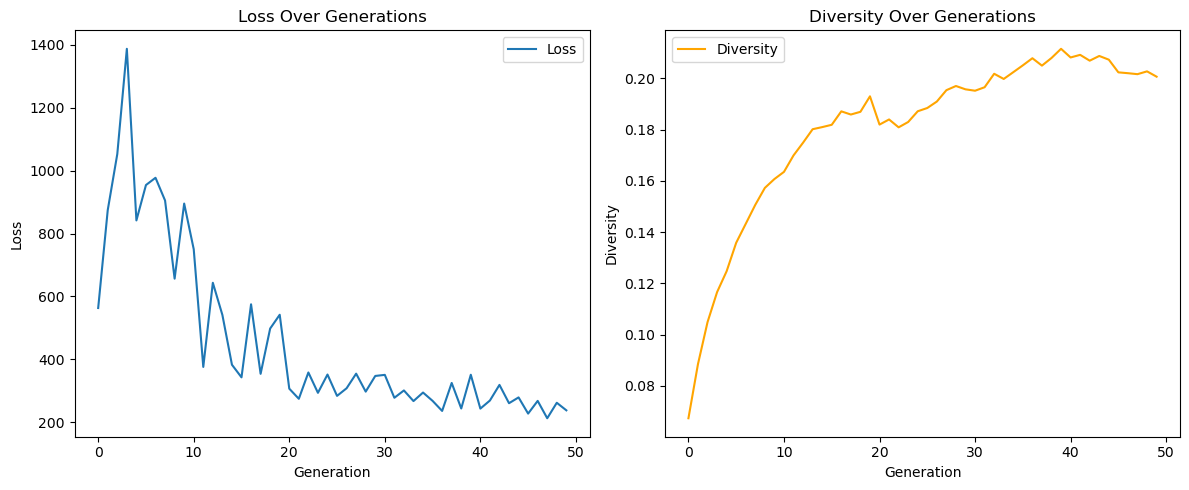

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_history, label='Loss')
plt.title('Loss Over Generations')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(diversity_history, label='Diversity', color='orange')
plt.title('Diversity Over Generations')
plt.xlabel('Generation')
plt.ylabel('Diversity')
plt.legend()

plt.tight_layout()
plt.show()